In [1]:
import argparse
import numpy as np

import matplotlib.pyplot as plt
from visualize import plot_decision_regions

### Helper functions

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))


def cross_entropy_loss(y_true, y_pred):
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def cross_entropy_gradient(y_true, y_pred):
    return (- y_true + y_pred) / (y_pred - y_pred ** 2)

### MLP Class

In [5]:
class MLP:
    def __init__(self, learning_rate=1, n_hidden_nodes=8, init_std=0.1):
        self.W1 = np.random.normal(0, init_std, [3, n_hidden_nodes])
        self.W2 = np.random.normal(0, init_std, [1 + n_hidden_nodes, 1])

        self.activation = sigmoid
        self.lr = learning_rate

    def predict(self, X):
        if X.shape[1] == self.W1.shape[0] - 1:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
        self.params = {'X': X}

        tmp = X.dot(self.W1)
        self.params['W1 @ X'] = tmp

        tmp = self.activation(tmp)
        tmp = np.concatenate([np.ones([X.shape[0], 1]), tmp], axis=1)
        self.params['g(W1 @ X)'] = tmp

        tmp = tmp.dot(self.W2)
        self.params['W2 @ g(W1 @ X)'] = tmp

        tmp = self.activation(tmp)
        self.params['g(W2 @ g(W1 @ X))'] = tmp

        return tmp

    def update_weights(self, y_true, y_pred):
        assert self.params != {}

        # ∂L/∂pred;  ∂Loss/∂Z2
        pd_loss = cross_entropy_gradient(y_true, y_pred)
        # print("y_true", y_true)
        # print("y_pred", y_pred)
        # print("pd_loss", pd_loss, pd_loss.shape)

        
        # ∂sigmoid(x)/∂x; ∂Z2/∂Q2
        pd_second_sigmoid = sigmoid_gradient(self.params['W2 @ g(W1 @ X)'])
        # print("self.params['W2 @ g(W1 @ X)']", self.params['W2 @ g(W1 @ X)'], self.params['W2 @ g(W1 @ X)'].shape)
        # print("pd_second_sigmoid", pd_second_sigmoid, pd_second_sigmoid.shape)

        
        # ∂(W2 @ g(W1 @ X))/∂ W2; ∂Q2/∂w2
        pd_matmul = self.params['g(W1 @ X)']
        # print("pd_matmul", pd_matmul, pd_matmul.shape)

        # save the post_w2_loss that captures cross entropy and final sigmoid
        post_w2_loss = pd_loss * pd_second_sigmoid
        # print("post_w2_loss", post_w2_loss, post_w2_loss.shape)
        temp = post_w2_loss * pd_matmul
        # print("temp_w2_update", temp, temp.shape)

        # Average the gradients over all the examples
        w2_update = np.mean(temp, axis=0, keepdims=True)
        # print("w2_update", w2_update, w2_update.shape)
        
        # ∂(W2 @ g(W1 @ X))/∂ g(W1 @ X); ∂Q2/∂Z1
        pd_W2_g = self.W2
        # print("pd_W2_g", pd_W2_g, pd_W2_g.shape)

        
        # ∂sigmoid(x)/∂x; ∂Z1/∂Q1
        pd_first_sigmoid = sigmoid_gradient(self.params['W1 @ X'])
        # print("pd_first_sigmoid", pd_first_sigmoid, pd_first_sigmoid.shape)

        
        # ∂(W1 @ X) /∂W1; ∂Q1/∂W1
        pd_W1_X = self.params['X']
        # print("pd_W1_X", pd_W1_X, pd_W1_X.shape)

        w1_update = np.zeros_like(self.W1)
        # print("w1_update", w1_update.shape)

        # for each node in the hidden layer ...
        for i in range(self.W1.shape[1]):
            # ... only grab the losses for one specific hidden node
            w1_loss = post_w2_loss * pd_W2_g[i + 1] * pd_first_sigmoid[:, (i, )]
            # print("pd_first_sigmoid[:, (i, )]", i, pd_first_sigmoid[:, (i, )], pd_first_sigmoid[:, (i, )].shape)
            # print("w1_loss", i, w1_loss, w1_loss.shape)
            w1_update[:, i] = np.mean(
                w1_loss * pd_W1_X, axis=0, keepdims=True)

        self.params = {}
        self.W1 -= self.lr * w1_update
        self.W2 -= self.lr * w2_update.T

    def fit(self, X, y, steps=10000, quiet=True):
        if X.shape[1] == self.W1.shape[1] - 1:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
        
        for i in range(steps):
            y_pred = self.predict(X)
            loss = cross_entropy_loss(y, y_pred)
            self.update_weights(y, y_pred)
            if not quiet and (i + 1) % (steps // 10) == 0:
                print(i + 1, np.mean(loss))

### Demo function

In [10]:
def demo(seed=1, lr=1.0, init_std=0.1, bonus=False, n_hidden_nodes=2, n_iters=10000, plot_before=False, verbose=False):
    np.random.seed(seed)

    # xor dataset
    X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]],
                 dtype=float)
    y = np.array([[0], [1], [1], [0]], dtype=float)

    # add more points
    if bonus:
        X_bonus = np.array([[0.25, 0.75], [0.5, 0.5], [0.75, 0.25]])
        y_bonus = np.array([[0], [1], [0]])
        X = np.concatenate([X, X_bonus], axis=0)
        y = np.concatenate([y, y_bonus], axis=0)

    # build MLP
    mlp = MLP(learning_rate=lr,
              init_std=init_std,
              n_hidden_nodes=n_hidden_nodes)

    if plot_before:
        plot_decision_regions(X, y, mlp)
        plt.show()

    mlp.fit(X, y, quiet=not verbose, steps=n_iters)

    print("{:.0f}% accuracy".format(
        100 * np.mean((mlp.predict(X) > 0.5) == y)))
    print(np.round(mlp.W1, 2))
    print(np.round(mlp.W2, 2))

    # plot the new decision boundaries
    plot_decision_regions(X, y, mlp)

    plt.show()
    plt.close('all')

### Original

100% accuracy
[[-9.55  3.3 ]
 [ 6.18 -7.81]
 [ 6.18 -7.82]]
[[  7.29]
 [-14.94]
 [-14.69]]


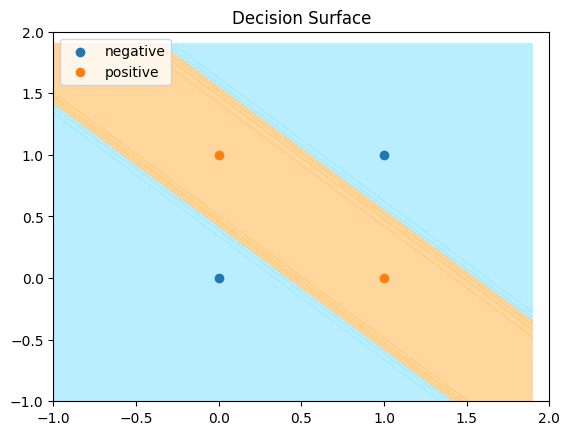

In [11]:
demo()

### random init

100% accuracy
[[-3.14  3.34]
 [ 5.89  6.76]
 [-6.18 -6.6 ]]
[[  4.77]
 [ 10.88]
 [-10.25]]


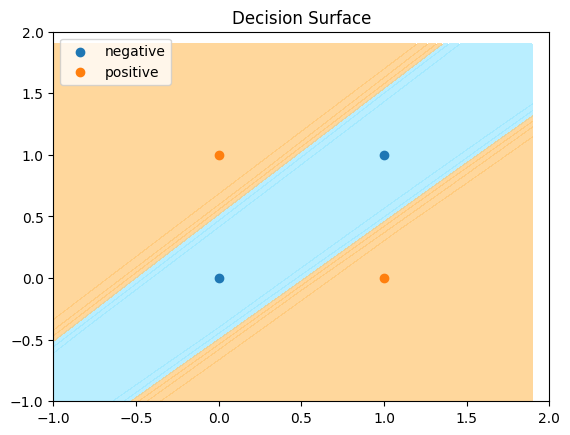

In [12]:
demo(seed=42)

### Bonus, add more points in the middle

71% accuracy
[[-6.43  2.46]
 [ 4.22 -6.19]
 [ 4.22 -6.19]]
[[ 1.53]
 [-9.18]
 [-9.1 ]]


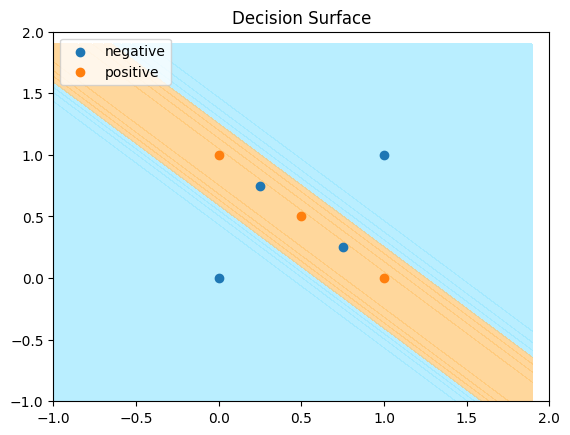

In [13]:
demo(bonus=True)

### increase the hidden nodes

86% accuracy
[[  5.92   6.45  -4.71   2.04]
 [ 15.48   4.7    2.9   -6.5 ]
 [ -8.63 -10.29   2.76  -6.5 ]]
[[  5.63]
 [-13.2 ]
 [  9.16]
 [ -5.52]
 [ -9.78]]


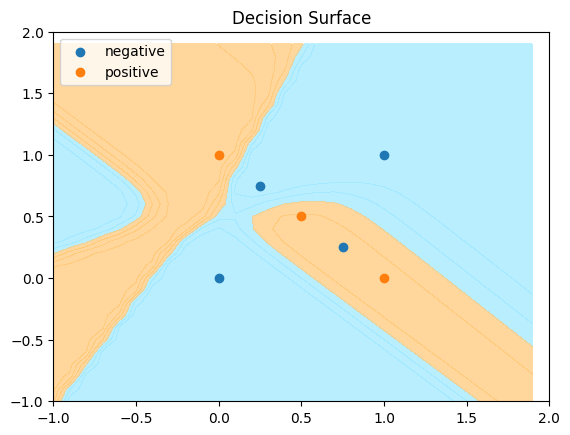

In [14]:
demo(bonus=True, n_hidden_nodes=4)

### Keep increasing the hidden nodes

57% accuracy
[[ 0.19  0.35 -0.07 -0.06  0.14 -0.34  0.16 -0.06]
 [ 0.35 -3.25  0.38 -0.39 -0.31  0.45  0.07 -0.12]
 [ 0.08 -3.24  0.23 -0.22 -0.41  0.52  0.03 -0.04]]
[[ 0.28]
 [-0.27]
 [-3.4 ]
 [-0.38]
 [ 0.48]
 [ 0.59]
 [-0.67]
 [ 0.01]
 [ 0.14]]


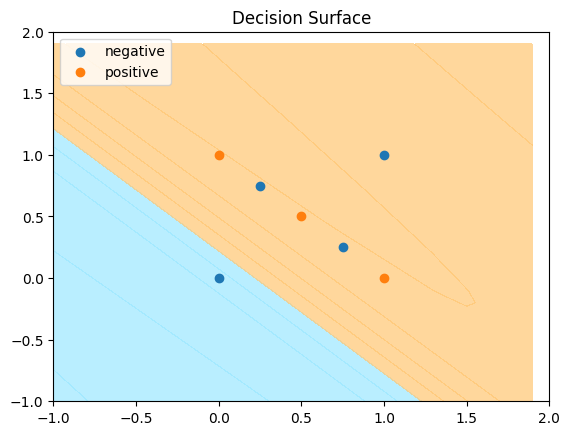

In [15]:
demo(bonus=True, n_hidden_nodes=8)

### Decrease the learning rate

57% accuracy
[[ 0.17 -0.07 -0.04 -0.1   0.09 -0.23  0.17 -0.06]
 [ 0.06 -0.07  0.14 -0.19 -0.03  0.02  0.08 -0.1 ]
 [-0.05 -0.11 -0.01  0.   -0.11  0.11  0.04  0.01]]
[[ 0.  ]
 [-0.12]
 [-0.08]
 [-0.13]
 [-0.03]
 [ 0.  ]
 [-0.1 ]
 [-0.03]
 [-0.1 ]]


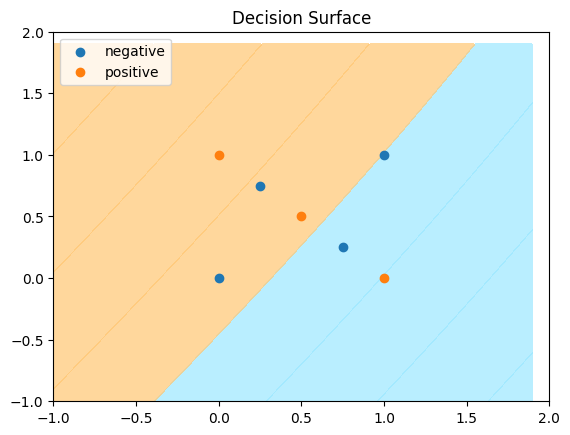

In [16]:
demo(bonus=True, n_hidden_nodes=8, lr=0.5)

57% accuracy
[[ 0.16 -0.06 -0.05 -0.1   0.09 -0.23  0.17 -0.07]
 [ 0.04 -0.03  0.15 -0.2  -0.03 -0.02  0.1  -0.1 ]
 [-0.03 -0.09 -0.    0.04 -0.11  0.11  0.07  0.04]]
[[ 0.01]
 [-0.11]
 [-0.06]
 [-0.13]
 [-0.05]
 [ 0.01]
 [-0.1 ]
 [-0.06]
 [-0.1 ]]


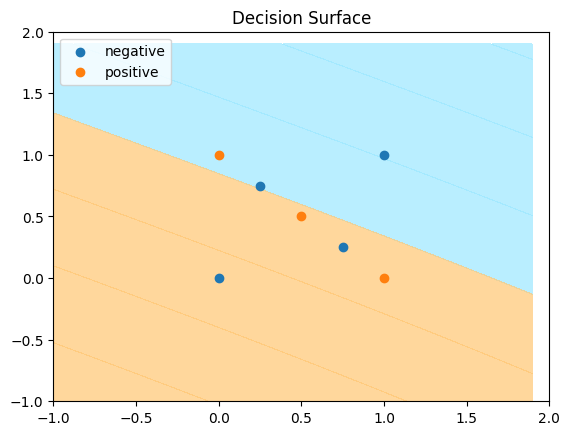

In [17]:
demo(bonus=True, n_hidden_nodes=8, lr=0.1)

### Increase the learning rate

100% accuracy
[[ 6.140e+00  3.380e+00 -1.000e-01  3.660e+00  5.500e+00 -4.710e+00
   1.000e-02 -5.220e+00]
 [ 1.521e+01 -7.070e+00  1.540e+00 -1.129e+01  6.930e+00  1.720e+00
  -6.300e-01  7.290e+00]
 [-8.280e+00 -6.800e+00 -6.000e-02  8.990e+00 -1.276e+01  4.180e+00
   5.700e-01 -1.324e+01]]
[[ -0.43]
 [-15.05]
 [-13.78]
 [ -2.81]
 [ 12.4 ]
 [ 12.33]
 [ -5.46]
 [ -0.2 ]
 [ 13.16]]


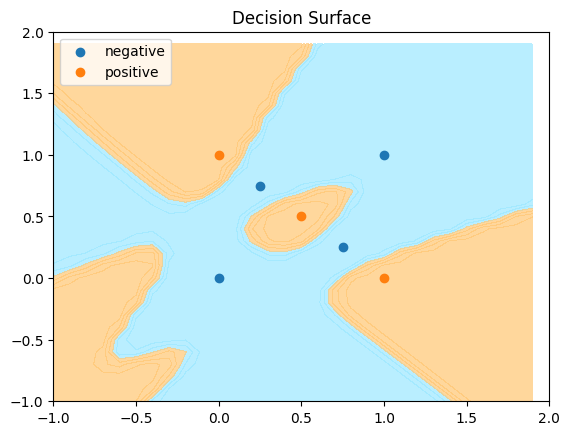

In [20]:
demo(bonus=True, n_hidden_nodes=8, lr=2)

### Increase the number of iterations

100% accuracy
[[  6.16   3.37   0.1    3.66   5.47  -4.72  -0.    -5.17]
 [ 15.3   -7.09   1.38 -11.29   6.85   1.62  -0.61   7.22]
 [ -8.34  -6.78   0.13   8.99 -12.65   4.3    0.52 -13.07]]
[[ -0.29]
 [-15.06]
 [-13.71]
 [ -2.75]
 [ 12.44]
 [ 12.15]
 [ -5.47]
 [ -0.1 ]
 [ 13.06]]


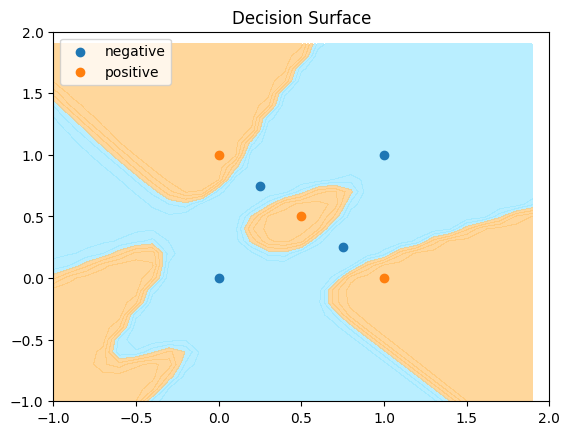

In [21]:
demo(bonus=True, n_hidden_nodes=8, n_iters=20000)

### Change the std

50% accuracy
[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.]
 [0.]
 [0.]]


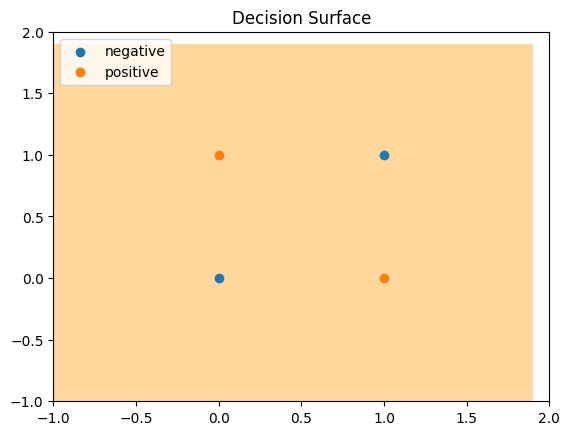

In [24]:
demo(init_std=0.0)

50% accuracy
[[ 15.85  -8.25]
 [ -5.67 -10.73]
 [  8.65 -23.02]]
[[ 12.55]
 [-12.55]
 [  2.43]]


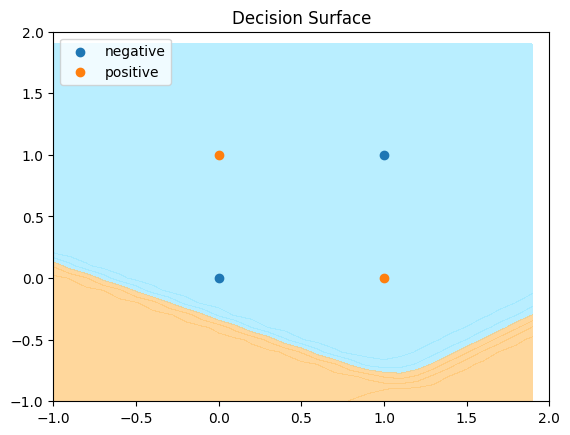

In [27]:
demo(init_std=10)

100% accuracy
[[-9.55  3.3 ]
 [ 6.18 -7.81]
 [ 6.18 -7.82]]
[[  7.29]
 [-14.94]
 [-14.69]]


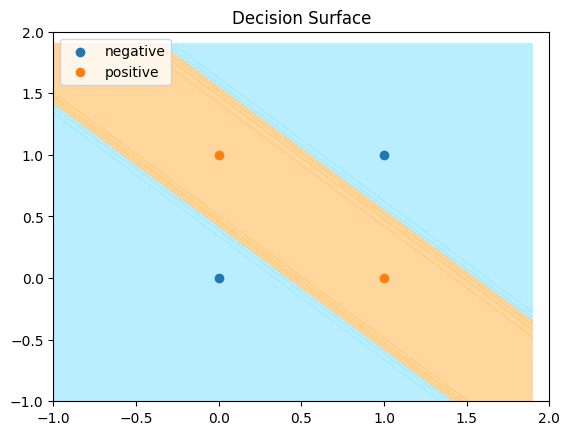

In [29]:
demo()